# Training of the English single language model

## 1. Install all needed requirements


In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!pip install -r /content/drive/MyDrive/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.4/796.4 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━

## 2. Initialize the GPU

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


## 3. Preprocessing of the data

First we need to open the English dataset and put it in a pandas DataFrame

In [4]:
import pandas as pd

df_en = pd.read_csv('/content/drive/MyDrive/data/paraphrases_en.csv')
df_en.head()

,Original,Parahprase
0,You can download the tool from this guide incl...,You can download the tool from this guide incl...
1,!{Star Trek} medals are used to unlock future ...,"With Star Trek medals, future episodes can be ..."
2,""" Egyptian mummies were made as """" built like ...",""" Egyptian mummies were made """" built like a p..."
3,""" Enablers"" , i.e. the basic building blocks w...",""" Fundamentals: basic building blocks for the ..."
4,""" I am very thankful for this USB Security sof...","""I am very grateful for this USB security soft..."


Divide the data into training (70%), validation (15%) and test (15%) sets

In [5]:
import numpy as np

df_train, df_validation, df_test = np.split(df_en.sample(frac=1), [int(.7*len(df_en)),int(.85*len(df_en))])
print(f"Total: {len(df_en)}")
print(f"Train: {len(df_train)}")
print(f"Validation: {len(df_validation)}")
print(f"Test: {len(df_test)}")

Total: 61000
Train: 42700
Validation: 9150
Test: 9150


Find a reasonable max_len for the sentences in the dataset

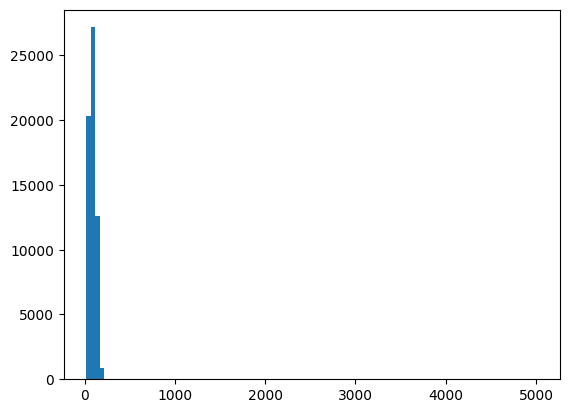

In [6]:
import matplotlib.pyplot as plt

train_lengths = df_train.apply(lambda x: max(len(x['Original']), len(x['Parahprase'])), axis=1).tolist()
val_lengths = df_validation.apply(lambda x: max(len(x['Original']), len(x['Parahprase'])), axis=1).tolist()
test_lengths = df_test.apply(lambda x: max(len(x['Original']), len(x['Parahprase'])), axis=1).tolist()

plt.hist(train_lengths + val_lengths + test_lengths, 100)
plt.show()

From the y-axis (characters), we can see that we can set the max_len at 16384

Now we will create the preprocessing function using the T5 tokenizer

In [7]:
from transformers import T5Tokenizer

checkpoint = 'google/mt5-small'
tokenizer = T5Tokenizer.from_pretrained(checkpoint)
max_length = 128

prefix = 'paraphrase: '

def preprocess_function(examples):
    originals = [prefix+s1 for s1 in examples['Original']]
    paraphrases = examples['Parahprase']

    encoding = tokenizer(
        originals, 
        text_target=paraphrases, 
        max_length=max_length, 
        truncation=True)
    
    return encoding

Apply the preprocessing function to the datasets

In [8]:
# Convert dataframes into datasets
from datasets import Dataset

ds_train = Dataset.from_pandas(df_train)
ds_val = Dataset.from_pandas(df_validation)
ds_test = Dataset.from_pandas(df_test)

In [9]:
# Preprocess on the GPU
tokenized_ds_train = ds_train.map(
    preprocess_function,
    batched=True,
    remove_columns=ds_train.column_names
)
tokenized_ds_val = ds_val.map(
    preprocess_function,
    batched=True,
    remove_columns=ds_val.column_names
)
tokenized_ds_test = ds_test.map(
    preprocess_function,
    batched=True,
    remove_columns=ds_test.column_names
)

Map:   0%|          | 0/42700 [00:00<?, ? examples/s]

Map:   0%|          | 0/9150 [00:00<?, ? examples/s]

Map:   0%|          | 0/9150 [00:00<?, ? examples/s]

## 2. Training of the data

We start by initializing the model, the datacollator and the parascore

---



In [11]:
from transformers import MT5ForConditionalGeneration, DataCollatorForSeq2Seq
from parascore import ParaScorer

checkpoint = 'google/mt5-small'
model = MT5ForConditionalGeneration.from_pretrained(checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
scorer = ParaScorer(lang='en', model_type='bert-base-uncased')

RuntimeError: ignored

RuntimeError: ignored

RuntimeError: ignored

RuntimeError: ignored

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Create a frunction that will compute the metrics

In [12]:
import numpy as np

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    
    scores = scorer.free_score(decoded_preds, decoded_labels)
    return {'parascore': float(sum(scores[0]) / len(scores[0]))}

Prepare the trainer

In [13]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

args = Seq2SeqTrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="epoch",
    output_dir='./content/drive/MyDrive/checkpoints/en',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=8,
    num_train_epochs=8,
    predict_with_generate=True,
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Start the training on the GPU

In [14]:
with tf.device(device_name):
    trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Parascore
1,1.953300,1.444117,0.862896
2,1.682500,1.334476,0.869309
3,1.542400,1.281877,0.869796
4,1.492200,1.254232,0.870072
5,1.470000,1.230313,0.870078
6,1.430200,1.221164,0.870115
7,1.435600,1.210918,0.870175
8,1.415800,1.206782,0.870190
